In [3]:
import numpy as np
import lasagne
import matplotlib.pyplot as plt
from fwrf.models import *
from fwrf.utils import make_rf_table
from scipy.stats.stats import pearsonr

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN not available)


In [4]:
%matplotlib inline

### Set up a fwrf with white noise training/val data

In [54]:
Ttrn,Tval,D,V,nmaps = 2040,301,17,4,8
deg_per_stim = 20
sf = 10

##feature maps
trn_feature_map_dict = {}
for ii in range(1,nmaps+1):
    input_name = 'fmap_%0.2d' % (ii)
    trn_feature_map_dict[input_name] = np.random.random((Ttrn,D,sf*ii,sf*ii)).astype('float32')

val_feature_map_dict = {}
for ii in range(1,nmaps+1):
    input_name = 'fmap_%0.2d' % (ii)
    val_feature_map_dict[input_name] = np.random.random((Tval,D,sf*ii,sf*ii)).astype('float32')

test_feature_map_dict = {}
for ii in range(1,nmaps+1):
    input_name = 'fmap_%0.2d' % (ii)
    test_feature_map_dict[input_name] = np.random.random((Tval,D,sf*ii,sf*ii)).astype('float32')
    

##true rfs
bound = int((deg_per_stim-3)/2.)
true_rfs = {k:np.random.randint(-bound,high=bound, size=V).astype('float32') for k in ['x0','y0']}
true_rfs['sig'] = np.random.randint(1,high=bound,size=V).astype('float32')

##random rfs
rand_rfs = {k:np.random.randint(-bound,high=bound, size=V).astype('float32') for k in ['x0','y0']}
rand_rfs['sig'] = np.random.randint(1,high=bound,size=V).astype('float32')


##true feature weights
true_NU = np.random.random((D*nmaps,V)).astype('float32')

#random feature weights
rand_NU = np.random.random((D*nmaps,V)).astype('float32')

##fwrf model
true_model = fwrf(val_feature_map_dict,deg_per_stim,V,rf_init=true_rfs, NU=true_NU)
true_model.normalize(lambda: (yield trn_feature_map_dict))

##true outputs, trn/val
trn_voxel_activity = true_model.predict(trn_feature_map_dict).astype('float32')
val_voxel_activity = true_model.predict(val_feature_map_dict).astype('float32')
test_voxel_activity = true_model.predict(test_feature_map_dict).astype('float32')

##data generator: note these are functions that *return* generators, so we can reboot the generator whenever.
trn_batch_size = Ttrn
val_batch_size = Tval
trn_data_gen = lambda: (({k:v[ii:ii+trn_batch_size,:,:,:] for k,v in trn_feature_map_dict.iteritems()}, trn_voxel_activity[ii:ii+trn_batch_size,:]) for ii in range(0,Ttrn,trn_batch_size))
val_data_gen = lambda: (({k:v[ii:ii+val_batch_size,:,:,:] for k,v in val_feature_map_dict.iteritems()}, val_voxel_activity[ii:ii+val_batch_size,:]) for ii in range(0,Tval,val_batch_size))       

##rf grid for coarse training
deg_per_radius = (1,deg_per_stim,3)
spacing = 5
rf_grid_df = make_rf_table(deg_per_stim,deg_per_radius,spacing,pix_per_stim = None)
G = rf_grid_df.shape[0]
rf_grid = {}
rf_grid['x0'] = rf_grid_df.x_deg.values.astype('float32')
rf_grid['y0'] = rf_grid_df.y_deg.values.astype('float32')
rf_grid['sig'] = rf_grid_df.deg_per_radius.values.astype('float32')
print G

48


### Coarse vs. fine training (deterministic gradient descent)

####  coarse only

In [74]:
coarse_model = fwrf(val_feature_map_dict,deg_per_stim,V,rf_init=rand_rfs, NU=rand_NU)
# coarse_model.normalize(lambda: (yield trn_feature_map_dict))
_=coarse_model.train_me(trn_data_gen, val_data_gen,
                        coarse=True,
                        rf_grid=rf_grid,
                        learning_rate=10e-6,
                        epochs=1,
                        num_iters = 150,
                        check_every=1,
                        print_stuff=True,
                        check_dims=False,
                        normalize=True,
                        consolidate=False)

will solve for: [feature_weights]
will update wrt: [feature_weights]
compiling...
=======epoch: 0
====iter: 0
number of improved models: 166
trn error: 18144288.000000
====iter: 1
number of improved models: 163
trn error: 17794248.000000
====iter: 2
number of improved models: 158
trn error: 17475388.000000
====iter: 3
number of improved models: 152
trn error: 17184774.000000
====iter: 4
number of improved models: 147
trn error: 16919772.000000
====iter: 5
number of improved models: 145
trn error: 16678006.000000
====iter: 6
number of improved models: 142
trn error: 16457323.000000
====iter: 7
number of improved models: 142
trn error: 16255786.000000
====iter: 8
number of improved models: 140
trn error: 16071637.000000
====iter: 9
number of improved models: 137
trn error: 15903294.000000
====iter: 10
number of improved models: 130
trn error: 15749318.000000
====iter: 11
number of improved models: 123
trn error: 15608412.000000
====iter: 12
number of improved models: 120
trn error: 15479

In [75]:
coarse_model.normalize(lambda: (yield trn_feature_map_dict))
test_pred_activity = coarse_model.predict(test_feature_map_dict)

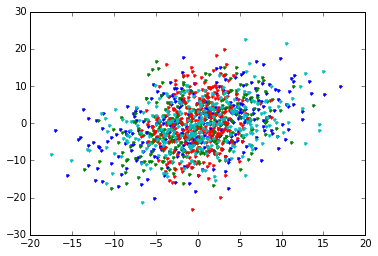

In [76]:
plt.plot(test_pred_activity, test_voxel_activity,'.')
# plt.axis('equal')

#### now try fine-tuning the coarse model

In [77]:
_=coarse_model.train_me(trn_data_gen, val_data_gen,
                      fine=True,
                      learning_rate=10e-12,
                      epochs=1,
                      num_iters = 500,
                      check_every=1,
                      print_stuff=True,
                      check_dims=False)

will solve for: [rf_fmap_08.x0, rf_fmap_08.y0, rf_fmap_08.sig, feature_weights]
will update wrt: [rf_fmap_08.x0, rf_fmap_08.y0, rf_fmap_08.sig, feature_weights]
compiling...
=======epoch: 0
====iter: 0
number of improved models: 3
trn error: 386748.500000
====iter: 1
number of improved models: 2
trn error: 386748.437500
====iter: 2
number of improved models: 2
trn error: 386748.312500
====iter: 3
number of improved models: 2
trn error: 386748.312500
====iter: 4
number of improved models: 1
trn error: 386748.281250
====iter: 5
number of improved models: 1
trn error: 386748.250000
====iter: 6
number of improved models: 1
trn error: 386748.250000
====iter: 7
number of improved models: 1
trn error: 386748.250000
====iter: 8
number of improved models: 1
trn error: 386748.218750
====iter: 9
number of improved models: 1
trn error: 386748.218750
====iter: 10
number of improved models: 1
trn error: 386748.218750
====iter: 11
number of improved models: 0
trn error: 386748.187500
====iter: 12
num

In [78]:
fine_test_pred_activity = coarse_model.predict(test_feature_map_dict)

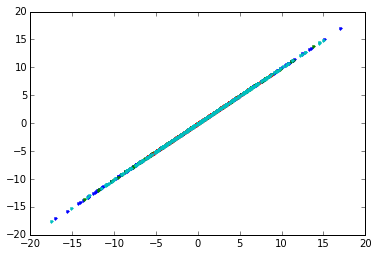

In [79]:
plt.plot(test_pred_activity, fine_test_pred_activity,'.')
# plt.axis('equal')

In [80]:
pearsonr(test_pred_activity.ravel(), test_voxel_activity.ravel())

(0.33853483, 1.1446729993170807e-33)

In [81]:
pearsonr(fine_test_pred_activity.ravel(), test_voxel_activity.ravel())

(0.33854133, 1.1412385629076278e-33)